In [1]:
import numpy as np
import pandas as pd
from os.path import join
from matplotlib import pyplot as plt

# EDA

In [2]:
!ls ../input/imedhub-internship/task_1/

README.md  class_a.npy	class_b.npy  field.npy


In [3]:
class_a = np.load(join('..', 'input', 'imedhub-internship', 'task_1', 'class_a.npy'))
class_b = np.load(join('..', 'input', 'imedhub-internship', 'task_1', 'class_b.npy'))
field = np.load(join('..', 'input', 'imedhub-internship', 'task_1', 'field.npy'))

In [4]:
class_a.shape, class_b.shape

((1000, 40, 60), (1000, 40, 60))

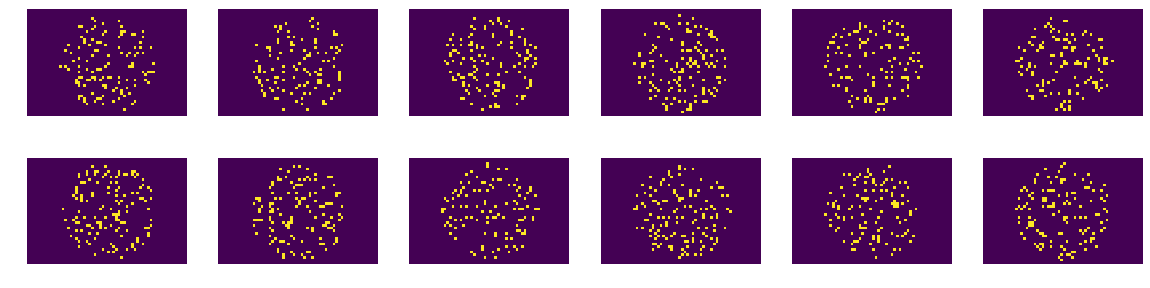

In [5]:
plt.figure(figsize=(20, 5))

for i in range(12):
    plt.subplot(2,6,i+1)
    plt.axis('off')
    plt.imshow(class_a[i])

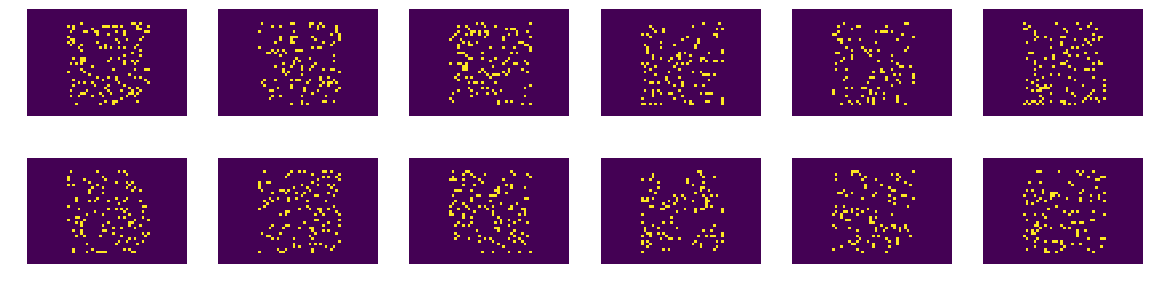

In [6]:
plt.figure(figsize=(20, 5))

for i in range(12):
    plt.subplot(2,6,i+1)
    plt.axis('off')
    plt.imshow(class_b[i])

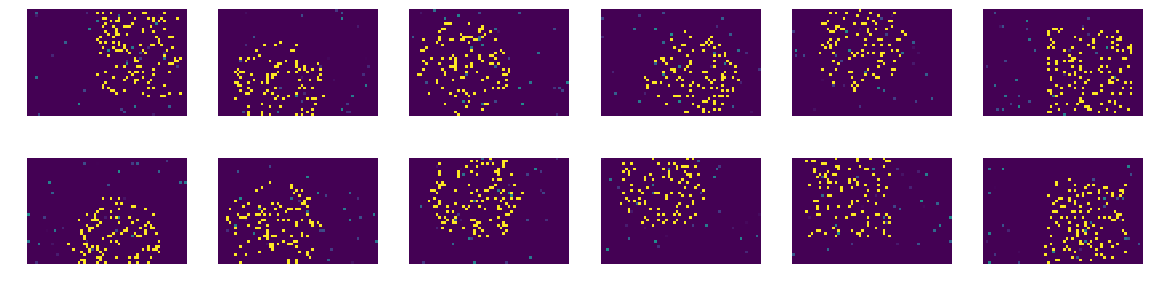

In [7]:
plt.figure(figsize=(20, 5))

for i in range(12):
    plt.subplot(2,6,i+1)
    plt.axis('off')
    plt.imshow(field[i])

In [8]:
f = field[15].copy()

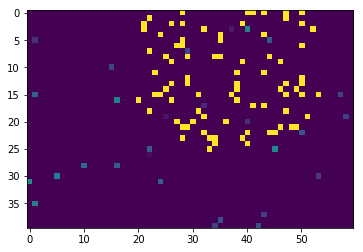

In [9]:
plt.imshow(f)

# Data Preparation

In [10]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, class_a, class_b, transform=None):
    
        self.class_a = class_a
        self.class_b = class_b
        self.len = self.class_a.shape[0] + self.class_b.shape[0]
        self.transform = transform

        
    def __getitem__(self, index: int) -> (np.ndarray, int):
        if index < 0 or index >= self.len:
            raise ValueError(f"Index must be between 0 and {self.len}")
        
        
        if index < self.class_a.shape[0]:
            img, label = self.class_a[index], 0
        else:
            img, label = self.class_b[index - self.class_a.shape[0]], 1
        
        if self.transform:
            img = self.transform(img)            
        
        return img, label

    
    def __len__(self):
        return self.len    

In [13]:
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomAffine(20, (0.3, 0.3), (0.8, 1.2), 3),
                                      # transforms.RandomResizedCrop((40, 60),(0.08, 1.0), (0.75, 1.3333333333333333), None),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),                                      
                                      transforms.ToTensor(),
                                      #transforms.Lambda(lambda x: x + (x == 0)*(torch.FloatTensor(x.shape).uniform_() > .99) * torch.FloatTensor(x.shape).uniform_()*0.3) ,
                                      transforms.Lambda(lambda x: x + (x == 0)*(torch.FloatTensor(x.shape).uniform_() > .99)*torch.FloatTensor(x.shape).uniform_()* 0.5) ,
                                      transforms.Normalize((0.5,), (0.5,))])

test_transforms = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

In [14]:
def load_class(path: str, train_fr=0.8, val_fr=0.1, test_fr=0.1):
    sum_fr = sum([train_fr, val_fr, test_fr])
    train_fr, val_fr = train_fr/sum_fr, val_fr/sum_fr
    
    cls = np.load(path).astype(np.float32)
    inds = np.random.permutation(cls.shape[0])
    slices_train, slices_val = int(cls.shape[0]*train_fr), int(cls.shape[0]*(val_fr+train_fr))
    train_idx, val_idx, test_idx  = inds[:slices_train], inds[slices_train:slices_val], inds[slices_val:]
    return cls[train_idx], cls[val_idx], cls[test_idx]

In [15]:
train_a, val_a, test_a = load_class(join('..', 'input', 'imedhub-internship', 'task_1', 'class_a.npy'))
train_b, val_b, test_b = load_class(join('..', 'input', 'imedhub-internship', 'task_1', 'class_b.npy'))

In [16]:
train_dataset = CustomDataset(train_a, train_b, train_transforms)
val_dataset = CustomDataset(val_a, val_b, train_transforms)
test_dataset = CustomDataset(test_a, test_b, train_transforms)

In [17]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1600, 200, 200)

In [18]:
dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}

In [19]:

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)


val_loader = DataLoader(dataset=val_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4)


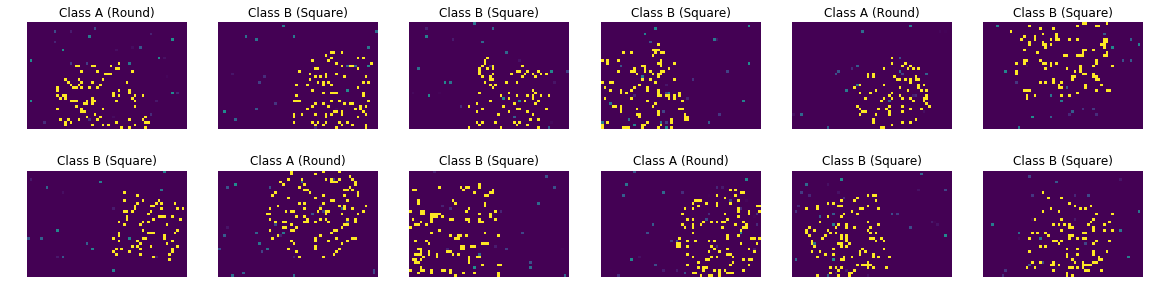

In [20]:
data, target = next(iter(train_loader))
data = data.squeeze()
plt.figure(figsize=(20, 5))

for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.axis('off')
    plt.title(['Class A (Round)', 'Class B (Square)'][target[i].item()])
    plt.imshow(data[i])



# Training

In [21]:
from torchvision.models import resnet34 as resnet
from copy import deepcopy
import matplotlib.pyplot as plt

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {'train':[], 'val':[]}
    acc_dict = {'train':[], 'val':[]}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, loss_dict, acc_dict

In [23]:
model = resnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 44.4MB/s]


In [24]:
state_dict = model.state_dict()
conv1_weight = state_dict['conv1.weight']
state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)

In [25]:
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
dataloaders = {"train": train_loader, "val": val_loader}

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
model = model.float().to(device)

In [29]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

In [30]:
%%time
model_ft,  loss_dict, acc_dict = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.7913 Acc: 0.4263
val Loss: 24493.2010 Acc: 0.5000

Epoch 1/99
----------
train Loss: 0.9312 Acc: 0.5138
val Loss: 446.7693 Acc: 0.5000

Epoch 2/99
----------
train Loss: 0.7852 Acc: 0.5131
val Loss: 25.5454 Acc: 0.5000

Epoch 3/99
----------
train Loss: 0.7559 Acc: 0.5356
val Loss: 0.9897 Acc: 0.5950

Epoch 4/99
----------
train Loss: 0.7108 Acc: 0.5356
val Loss: 0.7333 Acc: 0.4950

Epoch 5/99
----------
train Loss: 0.7279 Acc: 0.5269
val Loss: 0.6824 Acc: 0.5950

Epoch 6/99
----------
train Loss: 0.7007 Acc: 0.5219
val Loss: 0.6800 Acc: 0.5900

Epoch 7/99
----------
train Loss: 0.6980 Acc: 0.5669
val Loss: 0.6746 Acc: 0.6400

Epoch 8/99
----------
train Loss: 0.6939 Acc: 0.5381
val Loss: 0.6782 Acc: 0.5650

Epoch 9/99
----------
train Loss: 0.6952 Acc: 0.5850
val Loss: 0.7208 Acc: 0.5550

Epoch 10/99
----------
train Loss: 0.6624 Acc: 0.6369
val Loss: 0.6307 Acc: 0.6350

Epoch 11/99
----------
train Loss: 0.5743 Acc: 0.7087
val Loss: 0.6466 Acc: 0.6

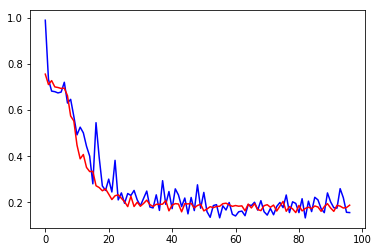

In [31]:
plt.plot(loss_dict['val'][3:], 'b')
plt.plot(loss_dict['train'][3:], 'r') 

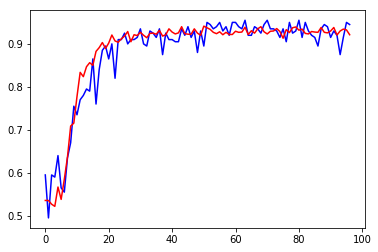

In [32]:
plt.plot(acc_dict['val'][3:], 'b')
plt.plot(acc_dict['train'][3:], 'r') 

In [33]:
correct_pred, num_examples = 0, 0
with torch.no_grad():
    for features, targets in test_loader:
        features = features.to(device)
        targets = targets.to(device)
        outputs = model_ft.forward(features)
        predicted_labels = torch.argmax(outputs, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    print(f"Accuracy score on Test set: {correct_pred.float().item()/num_examples * 100}%")

Accuracy score on Test set: 91.0%


# Evaluation

In [34]:
class CustomEvalDataset(Dataset):
    def __init__(self, cls, transform=None):
        self.cls = cls
        self.len = self.cls.shape[0]
        self.transform = transform

        
    def __getitem__(self, index: int) -> (np.ndarray, int):
        if index < 0 or index >= self.len:
            raise ValueError(f"Index must be between 0 and {self.len}")
        
        img = self.cls[index]
        
        if self.transform:
            img = self.transform(img)            
        
        return img

    
    def __len__(self):
        return self.len    

In [35]:
eval_dataset = CustomEvalDataset(field.astype(np.float32), test_transforms)

In [36]:
eval_loader = DataLoader(dataset=eval_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4)

In [37]:
pred = []
with torch.no_grad():
    for features in eval_loader:
        features = features.to(device).float()
        outputs = model_ft.forward(features)
        predicted_labels = torch.argmax(outputs, 1)
        pred += predicted_labels.tolist()
pred = np.asarray(pred)

In [38]:
sum(pred == 0)

101

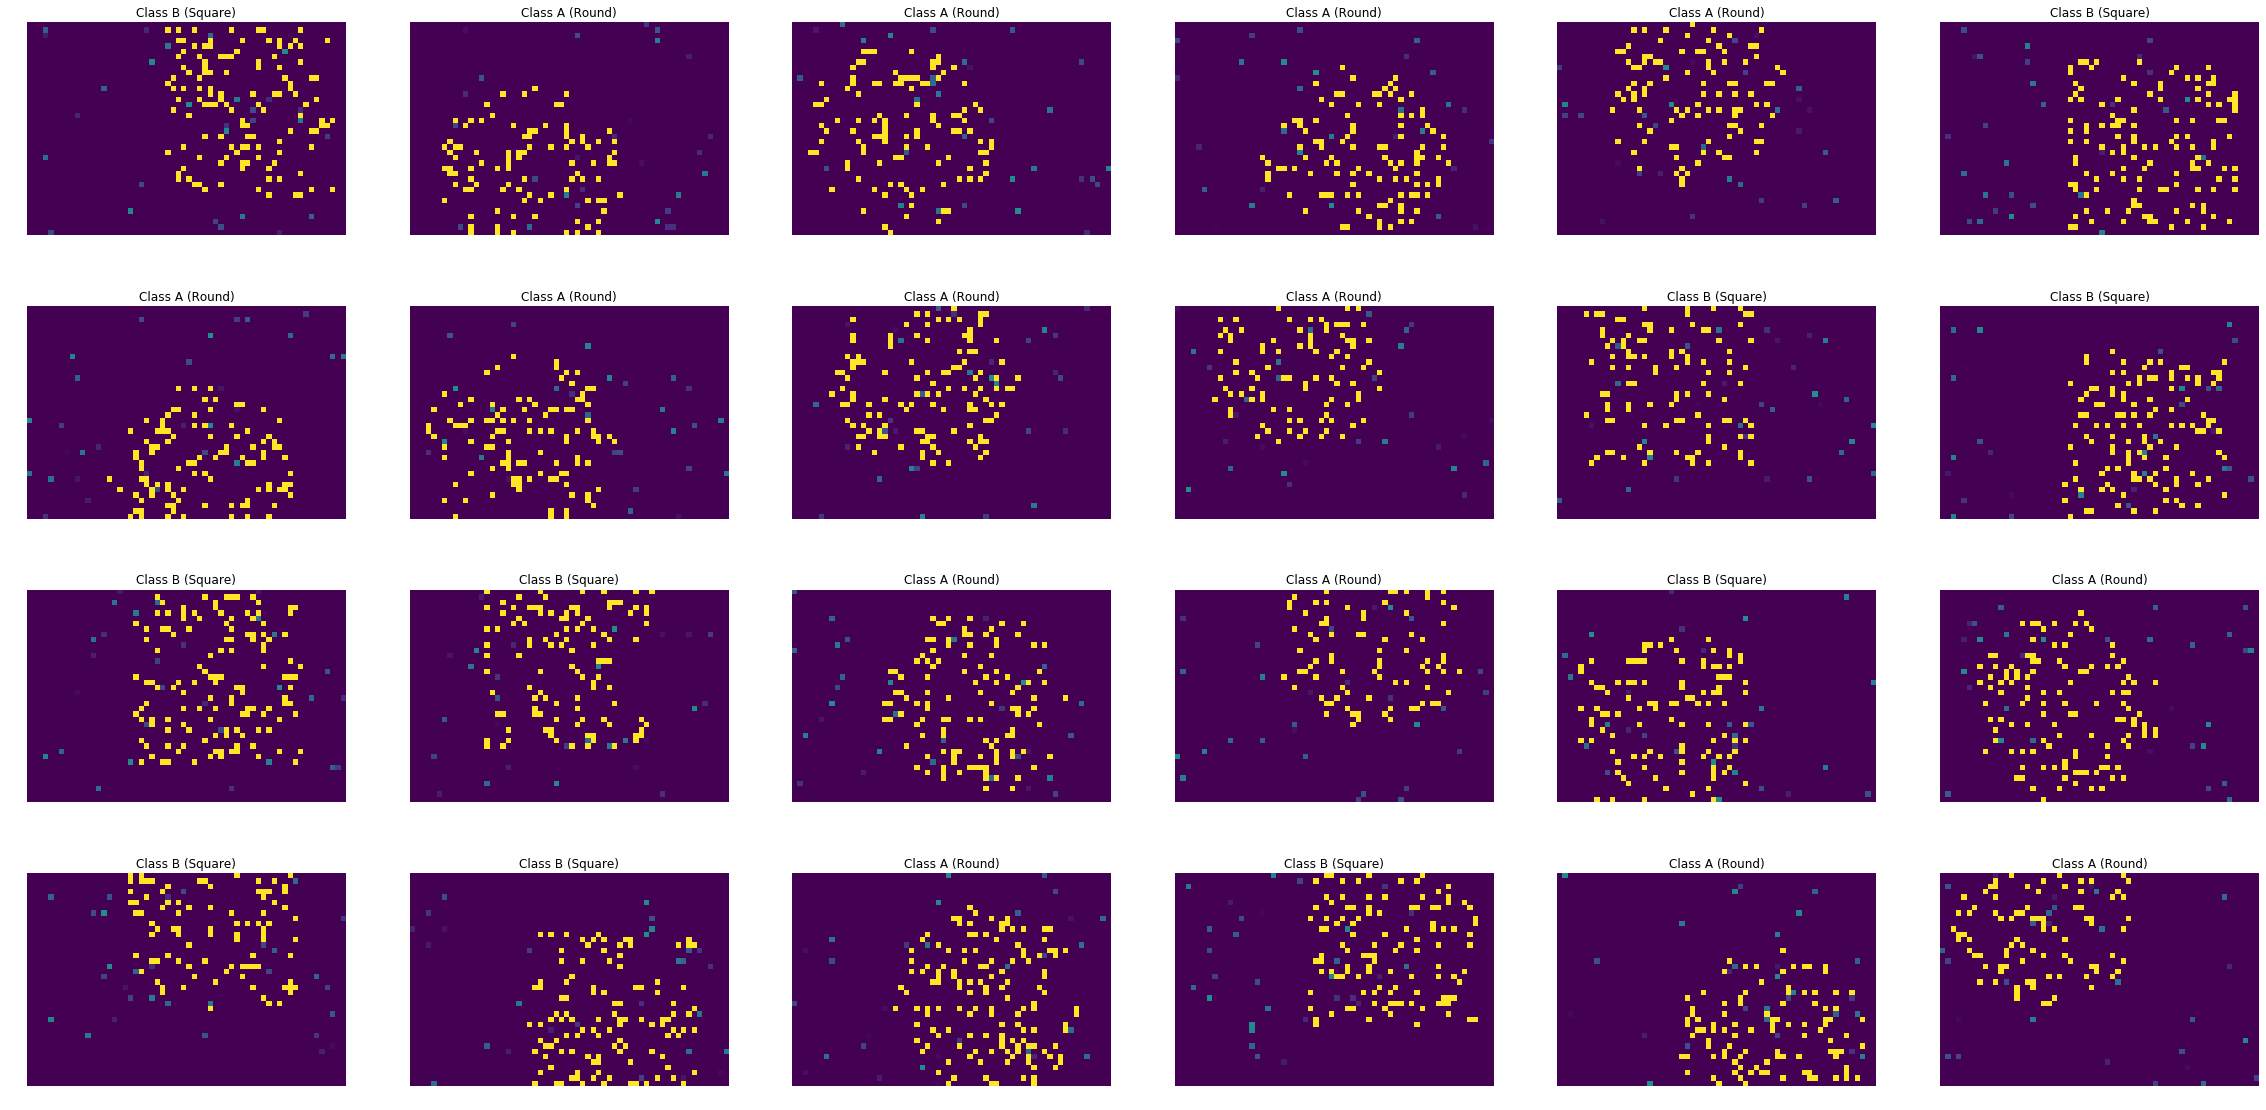

In [39]:
data = next(iter(eval_loader))
data = data.squeeze()
plt.figure(figsize=(40, 20))

for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.axis('off')
    plt.title(['Class A (Round)', 'Class B (Square)'][pred[i]])
    plt.imshow(data[i])

